## Classification

### Classification can be defined as prediction of one thing or another
Classification can be of different types. Below are some of the most common classification problems.

    1. Binary classification (one thing or another)
    2. Multi-class classification (one thing among many things)
    3. Multi-label classification (one thing can have mutiple labels)

### Importing libraries

In [670]:
import numpy as np
import torch as torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
from torch import nn

# Linear(straight-line) Layers only

 Only linear layers have been experimented to certain portrion. If you want to look at the actual code that works on a circlular dataset, you can skip to **Non-Linear layers**. 

### Getting data ready

In [671]:
from sklearn.datasets import make_circles

# Create circles
X, y = make_circles(n_samples = 1000,
                   noise = 0.03,
                   random_state = 42)

# This is a toy dataset. A toy dataset is small for experiment but sizeable enough to practice the fundametals

In [672]:
len(X), len(y)

(1000, 1000)

In [673]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [674]:
# Getting array into dataframe
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label" : y})
circles

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


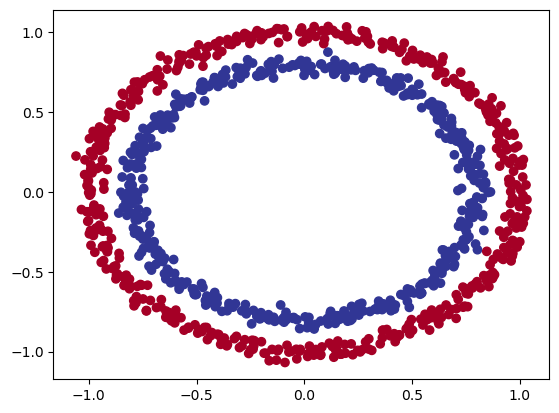

In [675]:
plt.scatter(x = circles["X1"],
            y = circles["X2"],
            c = y,
            cmap = plt.cm.RdYlBu)
plt.show()

In [676]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [677]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [678]:
X_train.dtype, X_train.shape

(torch.float32, torch.Size([700, 2]))

In [679]:
y_train.dtype, y_train.shape

(torch.float32, torch.Size([700]))

### Building a model

1. Setting up device agnoistic code for our code to run on GPU
2. Construct a model by subclassing `nn.module`
3. Define loss function and optimizer
4. Create a train and test loop

In [680]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [681]:
# Subclass `nn.Module`
class circleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Create `nn.Linear()` layers
        self.layer_1 = nn.Linear(in_features = 2, # takes the shape of X (which is 2 in our case)
                                out_features = 5) # upscales to 5 features
        
        self.layer_2 = nn.Linear(in_features = 5, 
                                out_features = 1)


    # Define a forward method
    def forward(self, x : torch.tensor) -> torch.tensor:
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2

# OR

In [682]:
# can be done with this method as well
sequential_method_model = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 5)).to('cuda')

sequential_method_model.parameters()



<generator object Module.parameters at 0x000001C89D161E00>

In [683]:
# Instantiate model
our_model = circleModelV1()

# model to GPU
our_model.to(device)

circleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [684]:
our_model.parameters

<bound method Module.parameters of circleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)>

In [690]:
# Instantiate model
our_model = circleModelV1()

# model to GPU
our_model.to(device)

circleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [686]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    acc = round(acc, 2)
    return acc

##### Going from :

#### raw logits -> predictions probabilities -> prediction labels

**logits** - raw outputs of the model with no activation function

Our model outputs are going to be raw **logits**

We can convert these **logits** into prediction probabilities by passing them to some kind of **activation function (e.g sigmoid for binary classification and softmax for multiclass classification)**

Then, we can convert our model's **prediction probabilities** to **prediction predictions** labels by either rounding them or taking the `argmax()`

# Below step must be followed inorder to make correct classification 

#example 

our_model.eval()
with torch.inference_mode():
####    raw logits -> prediction probabilities
    y_logits = our_model(X_test.to('cuda'))[:5]
    
####     applying activation function
    y_pred_probs = torch.sigmoid(y_logits)
    
####     prediction probabilities to prediction labels
    y_label = torch.round(y_pred_probs)
    
y_label

### Using sigmoid activation function

To turn **logits** to **prediction probabilities**

In [691]:
torch.cuda.manual_seed(42)


# defining loss function

# loss_fn = torch.nn.BCELoss() # requires input to have gone through sigmoid activation function beforehand

loss_fn = torch.nn.BCEWithLogitsLoss() # sigmoid activation function built-in

# defining optimizer
optimizer = torch.optim.SGD(our_model.parameters(),
                     lr = 0.01)


X_train = X_train.to('cuda')
X_test = X_test.to('cuda')
y_train = y_train.to('cuda')
y_test = y_test.to('cuda')

# Setting epochs
epochs = 100

for epoch in range(epochs):
    
    # In training mode
    our_model.train()
    
    # Forward pass
    training_logits= our_model(X_train).squeeze(dim = 1)
    training_preds = torch.round(torch.sigmoid(training_logits)) # calculating sigmoid predictions to calculate accuracy
    
    # Setting loss function / calculate accuracy
    training_loss = loss_fn(training_logits, y_train) #BCEwithlogitsloss() expects raw logits as input
    training_accuracy = accuracy_fn(y_true = y_train, y_pred = training_preds)
    
    # Setting optimizer
    optimizer.zero_grad()
    
    # Back propagation(loss)
    training_loss.backward()
    
    # Step optimizer (apply optimization to reduce the gradient(find minimum loss))
    optimizer.step()
    
    
    
#     ----------------------Testing-------------------------
    #model to evaluation mode
    our_model.eval()

    with torch.inference_mode():
        test_logits = our_model(X_test).squeeze(dim = 1)
        test_preds = torch.round(torch.sigmoid(test_logits)) 
    
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true = y_test, y_pred = test_preds)
    
    if epoch % 10 == 0:
        print(f"epoch : {epoch}")
        print(f"Training loss : {training_loss}")
        print(f"Training accuracy : {training_accuracy}")
        print(f"Test loss : {test_loss}")
        print(f"Test accuracy : {test_accuracy}")
        print()
            
        

    

epoch : 0
Training loss : 0.6967232823371887
Training accuracy : 40.29
Test loss : 0.6915053725242615
Test accuracy : 43.33

epoch : 10
Training loss : 0.6964571475982666
Training accuracy : 39.86
Test loss : 0.6914703845977783
Test accuracy : 43.0

epoch : 20
Training loss : 0.6962149143218994
Training accuracy : 43.0
Test loss : 0.6914494037628174
Test accuracy : 46.33

epoch : 30
Training loss : 0.69599449634552
Training accuracy : 44.29
Test loss : 0.6914405226707458
Test accuracy : 49.0

epoch : 40
Training loss : 0.695793628692627
Training accuracy : 44.57
Test loss : 0.6914421916007996
Test accuracy : 48.33

epoch : 50
Training loss : 0.6956104636192322
Training accuracy : 45.0
Test loss : 0.6914528608322144
Test accuracy : 49.0

epoch : 60
Training loss : 0.6954432129859924
Training accuracy : 45.57
Test loss : 0.6914711594581604
Test accuracy : 48.67

epoch : 70
Training loss : 0.6952905058860779
Training accuracy : 46.29
Test loss : 0.6914960741996765
Test accuracy : 49.33

e

our_model is not learning anything

### Importing functions from Daniel's Github (Getting some help)
https://github.com/mrdbourke/pytorch-deep-learning

In [692]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)
        

helper_functions.py already exists, skipping download


### Plotting decision boundry of the model (from helper function)

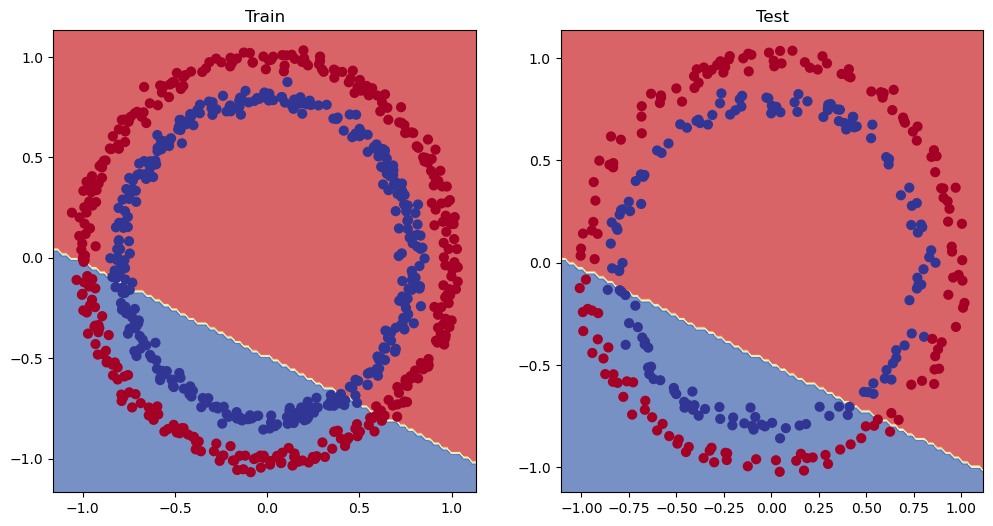

In [693]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(our_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(our_model, X_test, y_test)


### Improving a model (from a model perspective)

* Adding more layers - give the model more chances to learn about patterns in the data
* Adding more hidden units - go from 5 hidden units to 10 hidden units or more
* Fit longer (increase epochs)
* Changing the activation functions
* Changing the learning rate
* Changing loss function

**these are the HyperParameters**

In [694]:
torch.manual_seed(42)

class circleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features = 2,
                                out_features = 10)
        
        self.layer_2 = nn.Linear(in_features = 10,
                                out_features = 10)
        
        self.layer_3 = nn.Linear(in_features = 10,
                                out_features = 1)
        
    def forward(self, x : torch.tensor) -> torch.tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))
    


### Same model using `nn.Squential`

In [702]:
torch.manual_seed(42)

sequential_CirlceModelV2 = nn.Sequential(
                           nn.Linear(in_features = 2,
                                     out_features = 10),

                           nn.Linear(in_features = 10,
                                     out_features = 10),

                           nn.Linear(in_features = 10,
                                     out_features = 1) )


In [703]:
our_new_model = circleModelV2()

our_new_model.to('cuda')

circleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [704]:
torch.cuda.manual_seed(42)


# defining loss function for our_new_model

# loss_fn = torch.nn.BCELoss() # requires input to have gone through sigmoid activation function beforehand

loss_fn = torch.nn.BCEWithLogitsLoss() # sigmoid activation function built-in

# defining optimizer
optimizer = torch.optim.SGD(our_new_model.parameters(),
                     lr = 0.01)


X_train = X_train.to('cuda')
X_test = X_test.to('cuda')
y_train = y_train.to('cuda')
y_test = y_test.to('cuda')

# Setting epochs
epochs = 100

for epoch in range(epochs):
    
    # In training mode
    our_new_model.train()
    
    # Forward pass
    training_logits= our_new_model(X_train).squeeze(dim = 1)
    training_preds = torch.round(torch.sigmoid(training_logits)) # calculating sigmoid predictions to calculate accuracy
    
    # Setting loss function / calculate accuracy
    training_loss = loss_fn(training_logits, y_train) #BCEwithlogitsloss() expects raw logits as input
    training_accuracy = accuracy_fn(y_true = y_train, y_pred = training_preds)
    
    # Setting optimizer
    optimizer.zero_grad()
    
    # Back propagation(loss)
    training_loss.backward()
    
    # Step optimizer (apply optimization to reduce the gradient(find minimum loss))
    optimizer.step()
    
    
    
#     ----------------------Testing-------------------------
    #model to evaluation mode
    our_model.eval()

    with torch.inference_mode():
        test_logits = our_new_model(X_test).squeeze(dim = 1)
        test_preds = torch.round(torch.sigmoid(test_logits)) 
    
    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true = y_test, y_pred = test_preds)
    
    if epoch % 10 == 0:
        print(f"epoch : {epoch}")
        print(f"Training loss : {training_loss}")
        print(f"Training accuracy : {training_accuracy}")
        print(f"Test loss : {test_loss}")
        print(f"Test accuracy : {test_accuracy}")
        print()
            
        

epoch : 0
Training loss : 0.6949376463890076
Training accuracy : 51.86
Test loss : 0.6942620873451233
Test accuracy : 49.0

epoch : 10
Training loss : 0.6948675513267517
Training accuracy : 51.86
Test loss : 0.6941846609115601
Test accuracy : 49.0

epoch : 20
Training loss : 0.6948012113571167
Training accuracy : 52.0
Test loss : 0.6941129565238953
Test accuracy : 49.0

epoch : 30
Training loss : 0.6947383284568787
Training accuracy : 52.14
Test loss : 0.6940464377403259
Test accuracy : 49.33

epoch : 40
Training loss : 0.6946786642074585
Training accuracy : 52.29
Test loss : 0.6939848065376282
Test accuracy : 49.0

epoch : 50
Training loss : 0.6946219205856323
Training accuracy : 52.29
Test loss : 0.693927526473999
Test accuracy : 49.0

epoch : 60
Training loss : 0.6945679783821106
Training accuracy : 52.29
Test loss : 0.6938744187355042
Test accuracy : 49.0

epoch : 70
Training loss : 0.6945164799690247
Training accuracy : 52.14
Test loss : 0.6938251256942749
Test accuracy : 49.0

ep

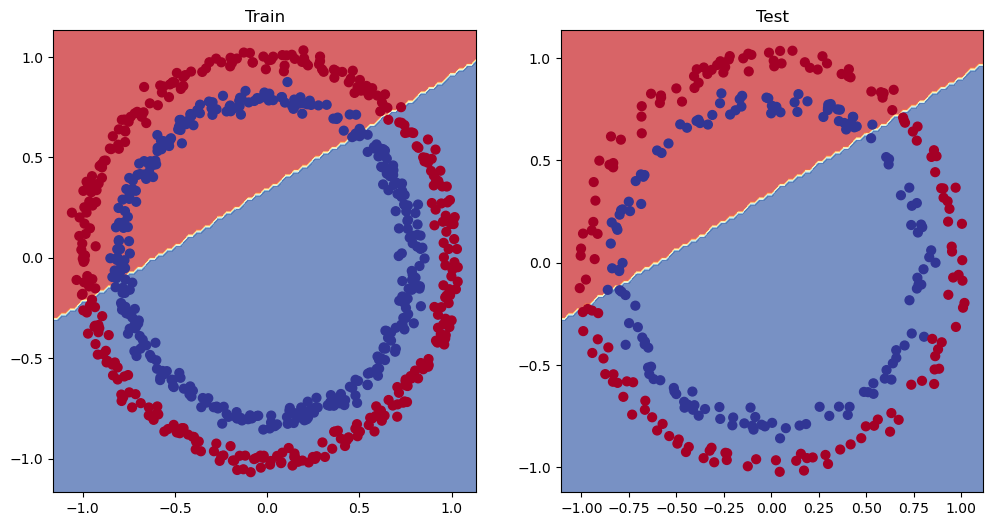

In [705]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(our_new_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(our_new_model, X_test, y_test)


#### Our_new_model is still not learning after those tweaks and modifications

One way to troubleshoot a larget problem is to test out a smaller problem.

In [733]:
# Creating some data

weight = 0.7
bias = 0.3

X_regression = torch.arange(0, 1, 0.01).unsqueeze(dim = 1)
y_regression = weight * X_regression + bias

# Checking data
print(len(X_regression))
print(len(y_regression))

X_regression[:5], y_regression[:5]

100
100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [755]:
# Train test split

train_split = round(0.8 * len(X_regression))

X_train_reg, y_train_reg = X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:], y_regression[train_split:]

X_train_reg.shape, X_test_reg.shape

(torch.Size([80, 1]), torch.Size([20, 1]))

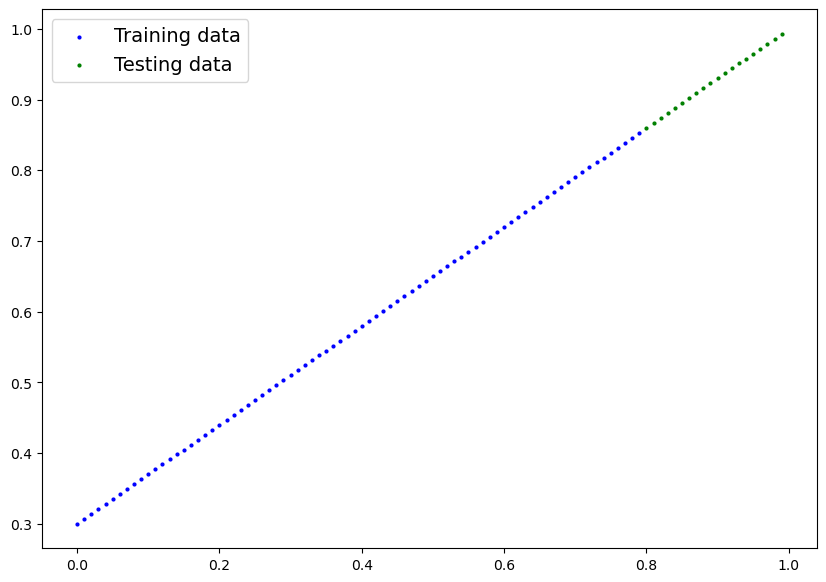

In [756]:
plot_predictions(train_data = X_train_reg,
                train_labels = y_train_reg,
                test_data = X_test_reg,
                test_labels = y_test_reg)

### Testing our model if its learning strainght line regression data

In [766]:

torch.manual_seed(42)

sequential_test_model = nn.Sequential(
                           nn.Linear(in_features = 1,
                                     out_features = 10),

                           nn.Linear(in_features = 10,
                                     out_features = 10),

                           nn.Linear(in_features = 10,
                                     out_features = 1) )

sequential_test_model.to('cuda')


Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [767]:
torch.cuda.manual_seed(42)


# defining loss function for our_new_model

# loss_fn = torch.nn.BCELoss() # requires input to have gone through sigmoid activation function beforehand

loss_fn = nn.L1Loss() # sigmoid activation function built-in

# defining optimizer
optimizer = torch.optim.SGD(sequential_test_model.parameters(),
                     lr = 0.001)


X_train_reg = X_train_reg.to('cuda')
X_test_reg = X_test_reg.to('cuda')
y_train_reg = y_train_reg.to('cuda')
y_test_reg = y_test_reg.to('cuda')

# Setting epochs
epochs = 1000

for epoch in range(epochs):
    
    # In training mode
    sequential_test_model.train()
    
    # Forward pass
    training_preds= sequential_test_model(X_train_reg)
    
    # Setting loss function / calculate accuracy
    training_loss = loss_fn(training_preds, y_train_reg) #BCEwithlogitsloss() expects raw logits as input
    
    # Setting optimizer
    optimizer.zero_grad()
    
    # Back propagation(loss)
    training_loss.backward()
    
    # Step optimizer (apply optimization to reduce the gradient(find minimum loss))
    optimizer.step()
    
    
    
#     ----------------------Testing-------------------------
    #model to evaluation mode
    sequential_test_model.eval()

    with torch.inference_mode():
        test_preds = sequential_test_model(X_test_reg)
        
    
    test_loss = loss_fn(test_preds, y_test_reg)
    
    if epoch % 10 == 0:
        print(f"epoch : {epoch}")
        print(f"Training loss : {training_loss}")
        print(f"Test loss : {test_loss}")
        print()
            
        

epoch : 0
Training loss : 0.7598585486412048
Test loss : 0.9496516585350037

epoch : 10
Training loss : 0.7221550941467285
Test loss : 0.9068909883499146

epoch : 20
Training loss : 0.6850382089614868
Test loss : 0.8647045493125916

epoch : 30
Training loss : 0.6484509706497192
Test loss : 0.823026180267334

epoch : 40
Training loss : 0.6123382449150085
Test loss : 0.7817914485931396

epoch : 50
Training loss : 0.5766465067863464
Test loss : 0.7409380078315735

epoch : 60
Training loss : 0.5413236618041992
Test loss : 0.7004044651985168

epoch : 70
Training loss : 0.5063187479972839
Test loss : 0.6601309776306152

epoch : 80
Training loss : 0.4715818464756012
Test loss : 0.6200591325759888

epoch : 90
Training loss : 0.43706414103507996
Test loss : 0.5801309943199158

epoch : 100
Training loss : 0.4027175009250641
Test loss : 0.5402895212173462

epoch : 110
Training loss : 0.3684943616390228
Test loss : 0.5004783868789673

epoch : 120
Training loss : 0.3343479335308075
Test loss : 0.46

In [768]:
X_train_reg.shape, y_train_reg.shape

(torch.Size([80, 1]), torch.Size([80, 1]))

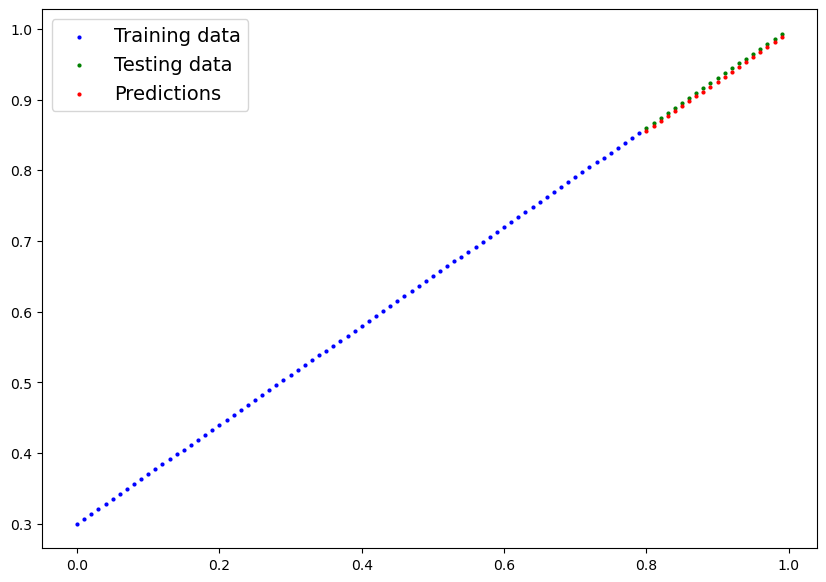

In [769]:
plot_predictions(train_data = X_train_reg.cpu(),
                train_labels = y_train_reg.cpu(),
                test_data = X_test_reg.cpu(),
                test_labels = y_test_reg.cpu(),
                predictions = test_preds.cpu());

# Adding Non-Linear(non-straight / curve line) layers

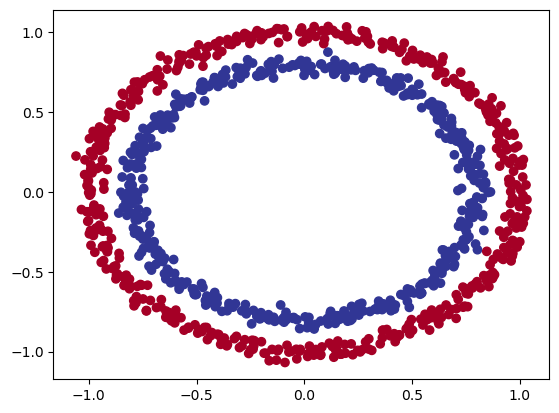

In [770]:
# Preparing dataset

X, y = make_circles(n_samples = 1000,
                   noise = 0.03,
                   random_state = 42)

plt.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.RdYlBu)
plt.show()


In [771]:
# Data to tensors and split data

import torch
from sklearn.model_selection import train_test_split

X = torch.tensor(X).type(torch.float32).to('cuda')
y = torch.tensor(y).type(torch.float32).to('cuda')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 42)

In [772]:
#### Building a model with non-linearity

from torch import nn


class circleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(in_features = 2,
                                out_features = 10)
        
        self.layer_2 = nn.Linear(in_features = 10,
                                out_features = 10)
        
        self.layer_3 = nn.Linear(in_features = 10,
                                out_features = 10)
        
        self.layer_4 = nn.Linear(in_features = 10,
                                out_features = 1)
        
        self.relu = nn.ReLU()  # ReLu() is a non-linear activation function
        
    def forward(self, x):
        return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

In [773]:
non_linear_model = circleModelV3()
non_linear_model.to('cuda')

circleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [774]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(non_linear_model.parameters(),
                           lr = 0.1)


In [783]:
## Training the model

X_train = X_train.to('cuda')
X_test = X_test.to('cuda')
y_train = y_train.to('cuda')
y_test = y_test.to('cuda')
non_linear_model.to('cuda')

torch.manual_seed(42)

epochs = 5000 # Set this value to 10000 for expected result

for epoch in range(epochs):
    
    non_linear_model.train()
    
    train_logits = non_linear_model(X_train).squeeze()
    train_preds = torch.round(torch.sigmoid(train_logits))
    
    training_accuracy = accuracy_fn(y_train, train_preds)

    train_loss = loss_fn(train_logits, y_train) # BCEWithLogitsLoss() requires logits to be passed in
    optimizer.zero_grad()
    
    train_loss.backward()
    optimizer.step()
    
    
## Testing the model
    
    non_linear_model.eval()
    
    with torch.inference_mode():
        test_logits = non_linear_model(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        
        test_accuracy = accuracy_fn(y_test, test_preds)
    
        test_loss = loss_fn(test_logits, y_test)
    
    if epoch % 10 == 0:
        print(f"\nepoch: {epoch} \nTrain accuracy : {training_accuracy} Train loss : {train_loss} \nTest accuracy : {test_accuracy} Test loss : {test_loss}")
    
    
    
    
    
    


epoch: 0 
Train accuracy : 100.0 Train loss : 0.0002367021661484614 
Test accuracy : 100.0 Test loss : 0.0016754281241446733

epoch: 10 
Train accuracy : 100.0 Train loss : 0.00023650405637454242 
Test accuracy : 100.0 Test loss : 0.0016751685179769993

epoch: 20 
Train accuracy : 100.0 Train loss : 0.00023630887153558433 
Test accuracy : 100.0 Test loss : 0.0016735454555600882

epoch: 30 
Train accuracy : 100.0 Train loss : 0.00023611492360942066 
Test accuracy : 100.0 Test loss : 0.0016731377691030502

epoch: 40 
Train accuracy : 100.0 Train loss : 0.0002359151840209961 
Test accuracy : 100.0 Test loss : 0.0016729346243664622

epoch: 50 
Train accuracy : 100.0 Train loss : 0.00023572162899654359 
Test accuracy : 100.0 Test loss : 0.0016714315861463547

epoch: 60 
Train accuracy : 100.0 Train loss : 0.00023552704078610986 
Test accuracy : 100.0 Test loss : 0.0016711442731320858

epoch: 70 
Train accuracy : 100.0 Train loss : 0.00023532779596280307 
Test accuracy : 100.0 Test loss : 0


epoch: 710 
Train accuracy : 100.0 Train loss : 0.00022341942531056702 
Test accuracy : 100.0 Test loss : 0.0016228473978117108

epoch: 720 
Train accuracy : 100.0 Train loss : 0.00022324424935504794 
Test accuracy : 100.0 Test loss : 0.0016213713679462671

epoch: 730 
Train accuracy : 100.0 Train loss : 0.00022306999017018825 
Test accuracy : 100.0 Test loss : 0.0016210715984925628

epoch: 740 
Train accuracy : 100.0 Train loss : 0.00022288998297881335 
Test accuracy : 100.0 Test loss : 0.0016207824228331447

epoch: 750 
Train accuracy : 100.0 Train loss : 0.00022271565103437752 
Test accuracy : 100.0 Test loss : 0.00161931780166924

epoch: 760 
Train accuracy : 100.0 Train loss : 0.0002225408097729087 
Test accuracy : 100.0 Test loss : 0.0016190748428925872

epoch: 770 
Train accuracy : 100.0 Train loss : 0.000222363174543716 
Test accuracy : 100.0 Test loss : 0.0016186933498829603

epoch: 780 
Train accuracy : 100.0 Train loss : 0.00022218833328224719 
Test accuracy : 100.0 Test lo


epoch: 1360 
Train accuracy : 100.0 Train loss : 0.00021242673392407596 
Test accuracy : 100.0 Test loss : 0.0015775253996253014

epoch: 1370 
Train accuracy : 100.0 Train loss : 0.00021226883109193295 
Test accuracy : 100.0 Test loss : 0.001577341347001493

epoch: 1380 
Train accuracy : 100.0 Train loss : 0.00021210956037975848 
Test accuracy : 100.0 Test loss : 0.0015771667240187526

epoch: 1390 
Train accuracy : 100.0 Train loss : 0.00021194688451942056 
Test accuracy : 100.0 Test loss : 0.0015757251530885696

epoch: 1400 
Train accuracy : 100.0 Train loss : 0.00021178733732085675 
Test accuracy : 100.0 Test loss : 0.0015754560008645058

epoch: 1410 
Train accuracy : 100.0 Train loss : 0.00021162573830224574 
Test accuracy : 100.0 Test loss : 0.0015753122279420495

epoch: 1420 
Train accuracy : 100.0 Train loss : 0.00021146758808754385 
Test accuracy : 100.0 Test loss : 0.0015738230431452394

epoch: 1430 
Train accuracy : 100.0 Train loss : 0.00021130999084562063 
Test accuracy : 1


epoch: 2060 
Train accuracy : 100.0 Train loss : 0.00020166742615401745 
Test accuracy : 100.0 Test loss : 0.0015337530057877302

epoch: 2070 
Train accuracy : 100.0 Train loss : 0.0002015243808273226 
Test accuracy : 100.0 Test loss : 0.0015336093492805958

epoch: 2080 
Train accuracy : 100.0 Train loss : 0.00020137618412263691 
Test accuracy : 100.0 Test loss : 0.0015334718627855182

epoch: 2090 
Train accuracy : 100.0 Train loss : 0.00020123121794313192 
Test accuracy : 100.0 Test loss : 0.0015320908278226852

epoch: 2100 
Train accuracy : 100.0 Train loss : 0.00020108703756704926 
Test accuracy : 100.0 Test loss : 0.001531849498860538

epoch: 2110 
Train accuracy : 100.0 Train loss : 0.0002009424933930859 
Test accuracy : 100.0 Test loss : 0.0015317481011152267

epoch: 2120 
Train accuracy : 100.0 Train loss : 0.0002007943403441459 
Test accuracy : 100.0 Test loss : 0.0015303228283300996

epoch: 2130 
Train accuracy : 100.0 Train loss : 0.00020065208082087338 
Test accuracy : 100.


epoch: 2730 
Train accuracy : 100.0 Train loss : 0.00019228928431402892 
Test accuracy : 100.0 Test loss : 0.0014954209327697754

epoch: 2740 
Train accuracy : 100.0 Train loss : 0.0001921554357977584 
Test accuracy : 100.0 Test loss : 0.0014953050995245576

epoch: 2750 
Train accuracy : 100.0 Train loss : 0.00019202435214538127 
Test accuracy : 100.0 Test loss : 0.001495197881013155

epoch: 2760 
Train accuracy : 100.0 Train loss : 0.00019188720034435391 
Test accuracy : 100.0 Test loss : 0.001494891825132072

epoch: 2770 
Train accuracy : 100.0 Train loss : 0.00019175669876858592 
Test accuracy : 100.0 Test loss : 0.001493610441684723

epoch: 2780 
Train accuracy : 100.0 Train loss : 0.00019162431999575347 
Test accuracy : 100.0 Test loss : 0.001493467134423554

epoch: 2790 
Train accuracy : 100.0 Train loss : 0.00019148840510752052 
Test accuracy : 100.0 Test loss : 0.001493216259405017

epoch: 2800 
Train accuracy : 100.0 Train loss : 0.0001913559972308576 
Test accuracy : 100.0 T


epoch: 3390 
Train accuracy : 100.0 Train loss : 0.00018381387053523213 
Test accuracy : 100.0 Test loss : 0.0014609263744205236

epoch: 3400 
Train accuracy : 100.0 Train loss : 0.00018369260942563415 
Test accuracy : 100.0 Test loss : 0.0014607469784095883

epoch: 3410 
Train accuracy : 100.0 Train loss : 0.0001835671573644504 
Test accuracy : 100.0 Test loss : 0.0014606299810111523

epoch: 3420 
Train accuracy : 100.0 Train loss : 0.00018344353884458542 
Test accuracy : 100.0 Test loss : 0.001459329854696989

epoch: 3430 
Train accuracy : 100.0 Train loss : 0.0001833226124290377 
Test accuracy : 100.0 Test loss : 0.0014590874779969454

epoch: 3440 
Train accuracy : 100.0 Train loss : 0.00018319951777812093 
Test accuracy : 100.0 Test loss : 0.0014590945793315768

epoch: 3450 
Train accuracy : 100.0 Train loss : 0.00018307816935703158 
Test accuracy : 100.0 Test loss : 0.0014578296104446054

epoch: 3460 
Train accuracy : 100.0 Train loss : 0.0001829598768381402 
Test accuracy : 100.


epoch: 4070 
Train accuracy : 100.0 Train loss : 0.00017578472034074366 
Test accuracy : 100.0 Test loss : 0.001427945215255022

epoch: 4080 
Train accuracy : 100.0 Train loss : 0.00017567304894328117 
Test accuracy : 100.0 Test loss : 0.0014278179733082652

epoch: 4090 
Train accuracy : 100.0 Train loss : 0.00017555875820107758 
Test accuracy : 100.0 Test loss : 0.0014276237925514579

epoch: 4100 
Train accuracy : 100.0 Train loss : 0.00017544454021845013 
Test accuracy : 100.0 Test loss : 0.0014264114433899522

epoch: 4110 
Train accuracy : 100.0 Train loss : 0.0001753345859469846 
Test accuracy : 100.0 Test loss : 0.0014261387987062335

epoch: 4120 
Train accuracy : 100.0 Train loss : 0.00017522135749459267 
Test accuracy : 100.0 Test loss : 0.0014261325122788548

epoch: 4130 
Train accuracy : 100.0 Train loss : 0.00017510767793282866 
Test accuracy : 100.0 Test loss : 0.0014248351799324155

epoch: 4140 
Train accuracy : 100.0 Train loss : 0.00017499738896731287 
Test accuracy : 10


epoch: 4750 
Train accuracy : 100.0 Train loss : 0.00016838786541484296 
Test accuracy : 100.0 Test loss : 0.0013974856119602919

epoch: 4760 
Train accuracy : 100.0 Train loss : 0.00016828125808387995 
Test accuracy : 100.0 Test loss : 0.001397263607941568

epoch: 4770 
Train accuracy : 100.0 Train loss : 0.00016817911819089204 
Test accuracy : 100.0 Test loss : 0.001396126695908606

epoch: 4780 
Train accuracy : 100.0 Train loss : 0.00016807540669105947 
Test accuracy : 100.0 Test loss : 0.001396047999151051

epoch: 4790 
Train accuracy : 100.0 Train loss : 0.00016796910495031625 
Test accuracy : 100.0 Test loss : 0.0013958917697891593

epoch: 4800 
Train accuracy : 100.0 Train loss : 0.0001678655535215512 
Test accuracy : 100.0 Test loss : 0.0013947277329862118

epoch: 4810 
Train accuracy : 100.0 Train loss : 0.00016776358825154603 
Test accuracy : 100.0 Test loss : 0.0013944956008344889

epoch: 4820 
Train accuracy : 100.0 Train loss : 0.00016765567124821246 
Test accuracy : 100.

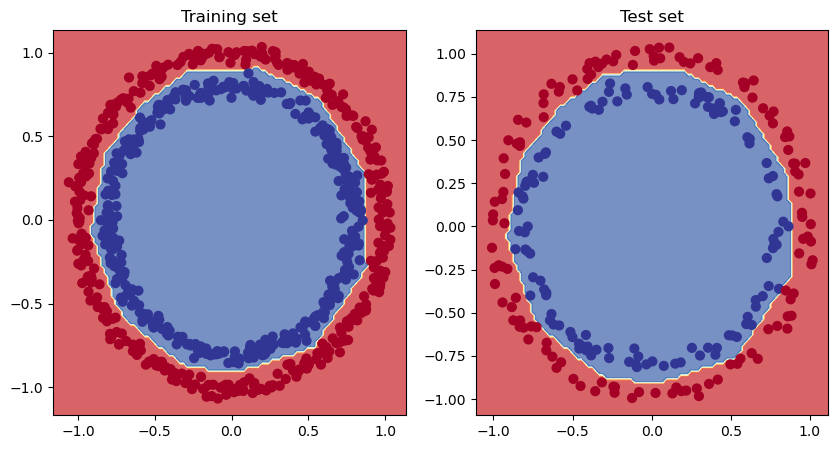

In [784]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.title("Training set")
plot_decision_boundary(non_linear_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test set")
plot_decision_boundary(non_linear_model, X_test, y_test)

plt.show()